In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from numpy.linalg import svd

In [10]:
def aaa_lite(f, Z, tol=1e-10, mmax=40, node_tol=1e-12):
    Z = np.asarray(Z)
    F = f(Z)
    N = Z.size

    S = []
    FS = []
    w  = None

    def r_eval(z):
        if len(S) == 0:
            z = np.atleast_1d(z)
            return np.zeros_like(z, dtype=complex)

        z = np.atleast_1d(z).astype(complex)
        out = np.empty_like(z, dtype=complex)
        out[:] = np.nan

        mask_done = np.zeros(z.shape, dtype=bool)
        for sj, fj in zip(S, FS):
            hit = np.abs(z - sj) < node_tol
            if np.any(hit):
                out[hit] = fj
                mask_done |= hit


        rem = ~mask_done
        if np.any(rem):
            zr = z[rem]
            denom = np.zeros_like(zr, dtype=complex)
            numer = np.zeros_like(zr, dtype=complex)
            for wj, sj, fj in zip(w, S, FS):
                term = 1.0 / (zr - sj)
                denom += wj * term
                numer += wj * fj * term
            out[rem] = numer / denom

        return out if out.shape != () else out.item()

    errs = []
    for it in range(mmax):

        R_all = r_eval(Z)


        mask_err = np.ones(N, dtype=bool)
        for sj in S:
            mask_err &= (np.abs(Z - sj) > node_tol)
        if not np.any(mask_err):
            errs.append(0.0)
            break

        err_vec = np.abs(F - R_all)[mask_err]
        max_err = np.max(err_vec)
        errs.append(max_err)
        if max_err < tol:
            break


        cand_idx = np.where(mask_err)[0]
        local_argmax = np.argmax(np.abs(F[cand_idx] - R_all[cand_idx]))
        idx = cand_idx[local_argmax]

        S.append(Z[idx]);  FS.append(F[idx])


        mask_rows = np.ones(N, dtype=bool)
        for sj in S:
            mask_rows &= (np.abs(Z - sj) > node_tol)
        Zm = Z[mask_rows];  Fm = F[mask_rows]

        m = len(S)
        A = np.empty((Zm.size, m), dtype=complex)
        for j, sj in enumerate(S):
            A[:, j] = (Fm - FS[j])/(Zm - sj)


        U, Sigma, Vh = np.linalg.svd(A, full_matrices=False)
        w = Vh.conj().T[:, -1]
        nrm = np.linalg.norm(w)
        if nrm > 0:
            w = w / nrm

    return np.array(S), np.array(FS), w, np.array(errs), r_eval

In [11]:
def f_gamma(x):
    return gamma(x)
N = 128
theta = 2*np.pi*np.arange(N)/N
Z = np.linspace(-3.5, 4.5, 400)
Z = Z[np.abs(Z - np.round(Z)) > 1e-12]

S, FS, w, errs, r = aaa_lite(f_gamma, Z, tol=1e-13, mmax=30)

print("support point =", S)
print("support points =", len(S))
print("final max error ≈", errs[-1])

support point = [-0.99373434 -1.9962406  -2.99874687 -1.87593985  0.00877193  4.5
  4.2593985   3.0764411  -3.5        -0.0112782  -3.01879699  1.53258145
  3.55764411 -1.01378446  4.47994987 -3.339599   -2.01629073]
support points = 17
final max error ≈ 9.303668946358812e-14


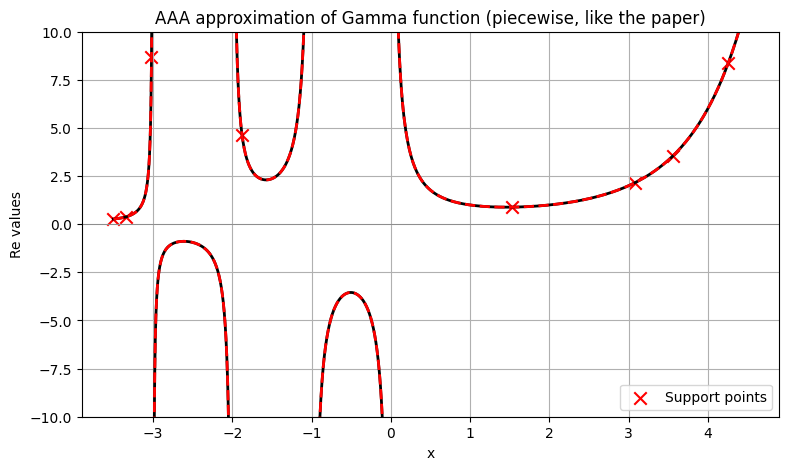

In [12]:
poles = np.array([0, -1, -2, -3])

segments = [(-3.5, -3.01), (-2.99, -2.01),
            (-1.99, -1.01), (-0.99, -0.01),
            (0.01, 4.5)]

plt.figure(figsize=(9,5))

for (a,b) in segments:
    xx = np.linspace(a,b,400)
    fx = f_gamma(xx)
    rx = r(xx)
    plt.plot(xx, np.real(fx), 'k-', lw=2)
    plt.plot(xx, np.real(rx), 'r--', lw=2)
plt.scatter(np.real(S), np.real(FS), c='red', marker='x', s=80, label="Support points")

plt.ylim(-10, 10)
plt.axhline(0, color='gray', lw=0.5)
plt.legend()
plt.title("AAA approximation of Gamma function (piecewise, like the paper)")
plt.xlabel("x")
plt.ylabel("Re values")
plt.grid(True)
plt.show()

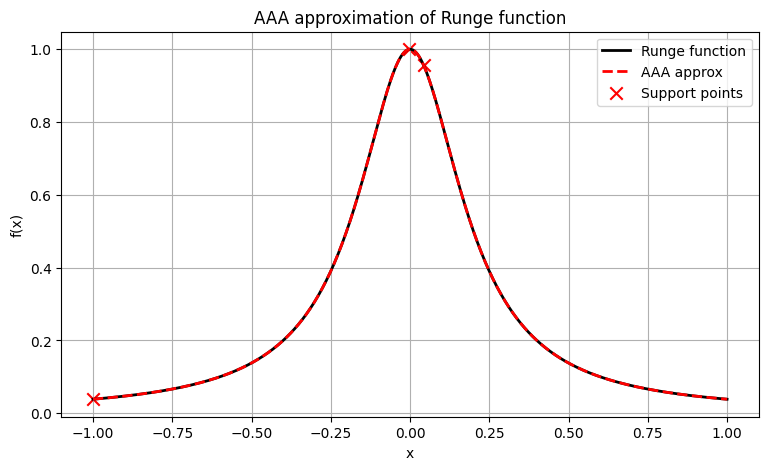

Weights w:
[-0.55340644+0.j  0.6224845 -0.j  0.55340253-0.j]
support point = [-0.00250627 -1.          0.04260652]
the number of support points = 3
final max error ≈ 1.1102230246251565e-15


In [13]:
def f_runge(x):
    return 1.0 / (1 + 25*x**2)

Z = np.linspace(-1, 1, 400)

S, FS, w, errs, r = aaa_lite(f_runge, Z, tol=1e-13, mmax=20)

x = np.linspace(-1, 1, 800)
fx = f_runge(x)
rx = r(x)

plt.figure(figsize=(9,5))
plt.plot(x, fx, 'k-', lw=2, label="Runge function")
plt.plot(x, rx.real, 'r--', lw=2, label="AAA approx")
plt.scatter(S, FS, c='red', marker='x', s=80, label="Support points")
plt.title("AAA approximation of Runge function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

print("Weights w:")
print(w)


test_x = np.linspace(-1, 1, 5)
print("support point =", S)
print("the number of support points =", len(S))
print("final max error ≈", errs[-1])

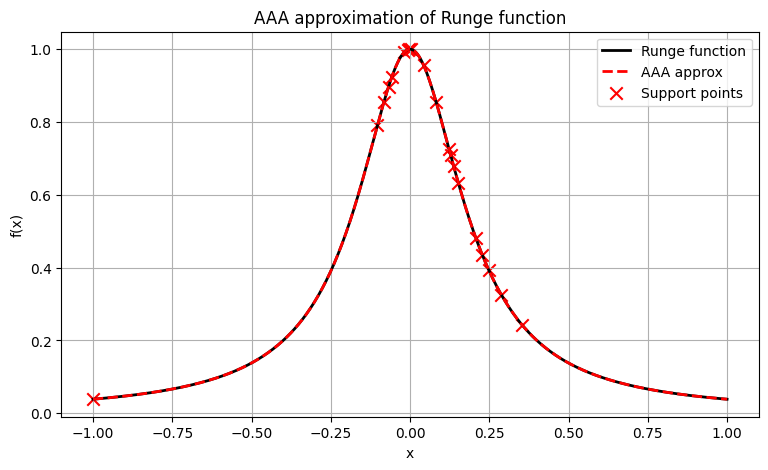

Weights w:
[ 0.1969162 -0.j -0.93117084+0.j -0.00153044+0.j -0.01042243+0.j
 -0.09407221+0.j -0.04348978+0.j -0.05302547+0.j -0.00460712+0.j
  0.06266929-0.j -0.00644867+0.j  0.16408539-0.j -0.02153427+0.j
 -0.1040122 +0.j  0.06078668-0.j -0.04486053+0.j -0.15752857+0.j
  0.02717933-0.j -0.02356315+0.j -0.07948117+0.j  0.01227996-0.j]
support point = [-0.00250627 -1.          0.04260652 -0.10275689  0.00250627  0.35338346
 -0.0075188   0.08270677  0.12280702  0.20802005 -0.01754386  0.28822055
  0.12781955  0.2481203   0.15288221  0.22807018 -0.08270677 -0.05764411
  0.13784461 -0.06766917]
the number of support points = 20
final max error ≈ 2.7755575615628914e-15


In [15]:
S, FS, w, errs, r = aaa_lite(f_runge, Z, tol=1e-15, mmax=20)

x = np.linspace(-1, 1, 800)
fx = f_runge(x)
rx = r(x)

plt.figure(figsize=(9,5))
plt.plot(x, fx, 'k-', lw=2, label="Runge function")
plt.plot(x, rx.real, 'r--', lw=2, label="AAA approx")
plt.scatter(S, FS, c='red', marker='x', s=80, label="Support points")
plt.title("AAA approximation of Runge function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

print("Weights w:")
print(w)

test_x = np.linspace(-1, 1, 5)
print("support point =", S)
print("the number of support points =", len(S))
print("final max error ≈", errs[-1])